In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Activation, Add, Dropout, Conv2D, Dense, Flatten, Layer, Conv2DTranspose, LeakyReLU, Reshape, GlobalMaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Mean
import tensorflow_addons as tfa
from tensorflow.keras.activations import sigmoid
import matplotlib.pyplot as plt
from helper_functions2 import get_imgs, load_caps_img, create_image_gen, make_gallery, draw2

# Load captions and images

In [2]:
image_shape = (128, 128, 3)
use_all_data = False
max_epoch = 500
latent_dim = 128

num_layer = 5
channel_multiplier = 8

l2_reg = 0.001
droprate = 0.1
kl_weight = 1

In [3]:
batch_size = 100

dataset_name = 'train'
train_capspath, train_imgspath = get_imgs(dataset_name)
train_caps, train_imgs = load_caps_img(train_capspath, train_imgspath, dataset_name, use_all_data)

dataset_name = 'test'
test_capspath, test_imgspath = get_imgs(dataset_name)
test_imgs = load_caps_img(test_capspath, test_imgspath, dataset_name, use_all_data)

train_dataset = create_image_gen(train_imgs, batch_size, image_shape[0])
test_dataset = create_image_gen(test_imgs, batch_size, image_shape[0])

./annotations/captions_train2014.json /users/apokkunu/trial/img/train2014/

dataset size: 82783

temp dataset size: 100
./annotations/image_info_test2014.json /users/apokkunu/trial/img/test2014/

dataset size: 40775

temp dataset size: 100

dataset size: 100

dataset size: 100


# VAE - Change Model

In [4]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal([batch, dim])
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

img_shape = 128
use_batch_norm = False
use_dropout = True
droprate = 0.3
kl_weight = 0.1

input_dim = (img_shape, img_shape, 3)
encoder_inputs = Input(shape = input_dim, name = 'encoder_input')

conv_filters = [64, 128, 256, 512, 1024]
conv_kernel_size = [4, 4, 4, 4, 4]
conv_strides = [2, 2, 2, 2, 2]
n_layers = len(conv_filters)

x = encoder_inputs

for i in range(n_layers):
    x = Conv2D(filters = conv_filters[i], kernel_size = conv_kernel_size[i], strides = conv_strides[i], padding = 'same')(x)
    
    if use_batch_norm:
        x = BatchNormalization()(x)
    
    x = LeakyReLU()(x)
    
    if use_dropout:
        x = Dropout(rate=droprate)(x)

x_before = x.shape[1:]
x = Flatten()(x)
x_after = x.shape[1]
x = Dense(768, activation=tf.nn.leaky_relu)(x)

z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# In[9]:


latent_inputs = Input(shape = (latent_dim,) , name = 'decoder_input')
x = Dense(768, activation=tf.nn.leaky_relu)(latent_inputs)
x = Dense(x_after, activation=tf.nn.leaky_relu)(x)
x = Reshape(x_before)(x)

conv_filters = [512, 256, 128, 64, 3]
n_layers = len(conv_filters)

for i in range(n_layers):
    x = Conv2DTranspose(filters=conv_filters[i], 
                        kernel_size=conv_kernel_size[i], strides = conv_strides[i], padding = 'same')(x)
    
    if use_batch_norm:
        x = BatchNormalization()(x)
    
    if i < n_layers - 1:
        x = LeakyReLU()(x)
        
        if use_dropout:
            x = Dropout(rate=droprate)(x)
            
    else:
        x = sigmoid(x)

decoder = Model(latent_inputs, x, name="decoder")
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3136        encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 64, 64)   0           leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [5]:
# model_encoder, last_conv_shape = create_encoder(latent_dim, num_layer, channel_multiplier)
# model_decoder = create_decoder(latent_dim, last_conv_shape, num_layer)

def load_model(model, path, name):
    model.trainable = False
    model.load_weights(path + name)
    model.summary()
    return model

# Predict

In [6]:
path = '/users/apokkunu/trial/img/vae/good_trials/output25/'
ncols = 10
epoch = 0
color_mode = True
save_path = './'
save = False
name = 'test'

en = load_model(encoder, path, 'en_im_660.h5')
dec = load_model(decoder, path, 'de_im_660.h5')

def plot_muvar(z_mu, z_std):
    f,ax = plt.subplots(1,2,figsize=(15,4))
    ax[0].scatter( range(z_mu.shape[1]), np.mean(z_mu, axis=0) )
    ax[0].set_title('Mean', size=15)
    ax[1].scatter( range(z_std.shape[1]), np.mean( np.exp(z_std), axis=0))
    ax[1].set_title('Std', size=15)
    plt.show()
    plt.close()

def predict_direct(model_en, model_de, data):
    zm, zv, z = model_en.predict(data)
    plot_muvar(zm, zv)
    reconstruction = model_de.predict(z)
    return reconstruction

def show_pred_images(model_encoder, model_decoder, dataset, name):
    for batch in dataset.take(1):
        print('\n' + name)
        make_gallery(batch.numpy()[:100], ncols, epoch, name, color_mode, save_path, save)
        
        x_decoded = predict_direct(model_encoder, model_decoder, batch.numpy())[:batch_size, :, :, :]
        make_gallery(x_decoded[:100], ncols, epoch, name, color_mode, save_path, save)
        
        for i in range(10):
            draw2(batch.numpy()[i], x_decoded[i], color_mode, save_path, save, epoch, name)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3136        encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 64, 64)   0           leaky_re_lu[0][0]                
____________________________________________________________________________________________


train images


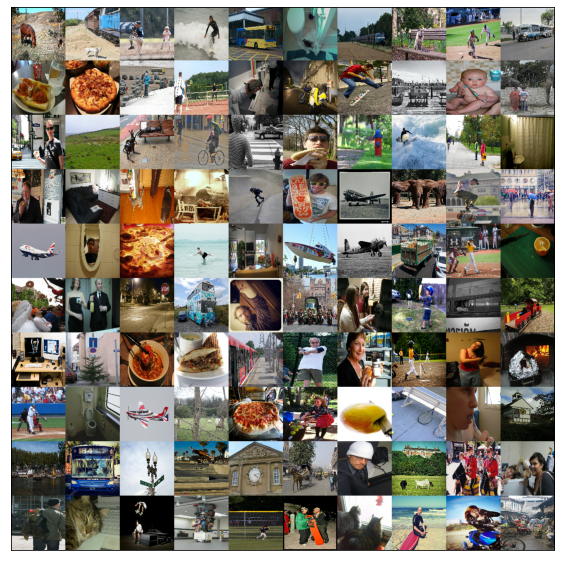

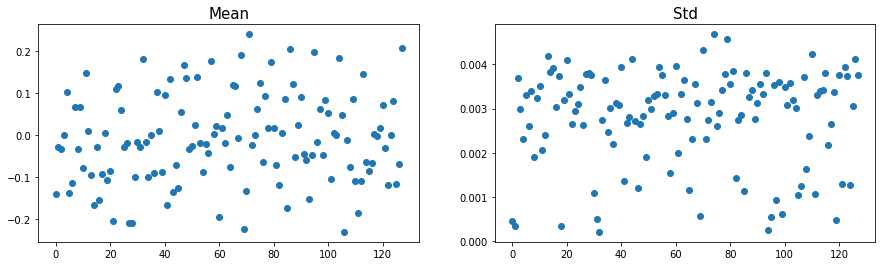

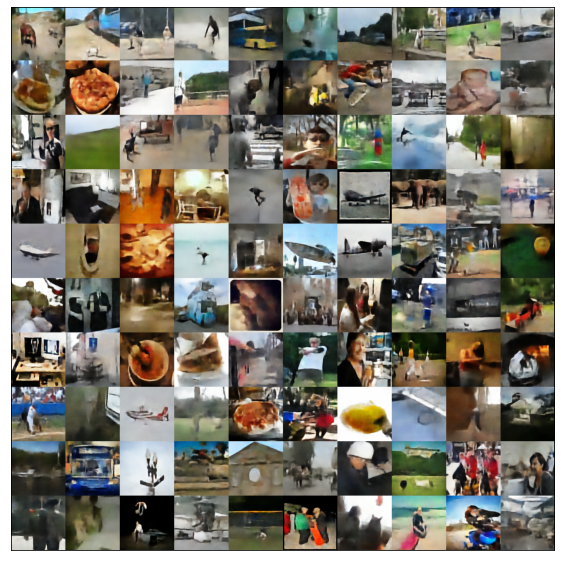

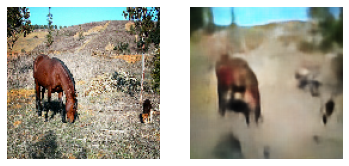

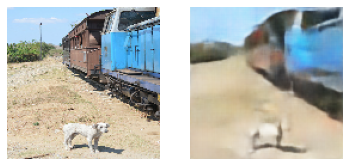

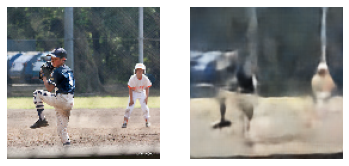

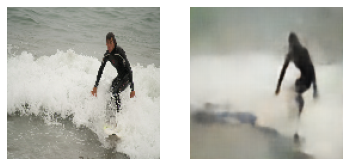

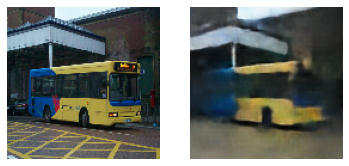

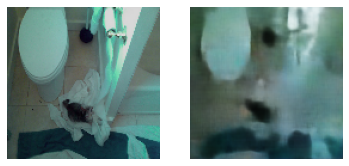

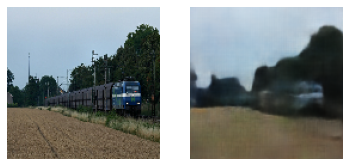

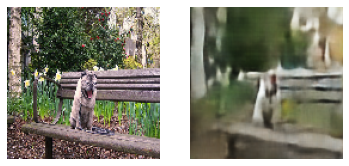

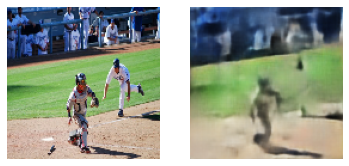

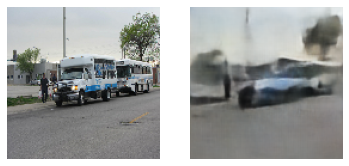


test images


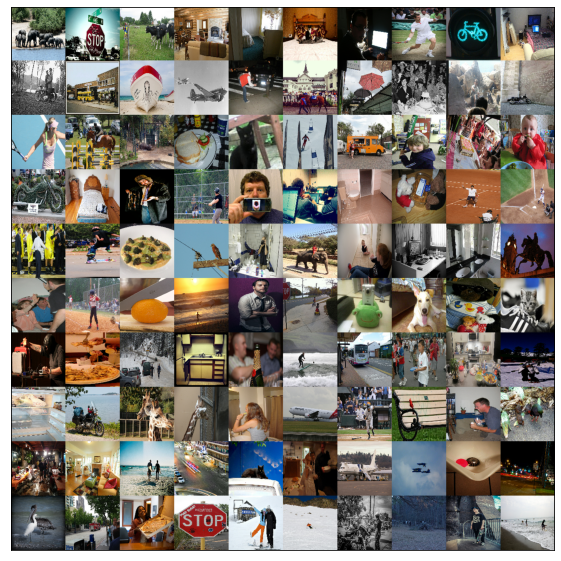

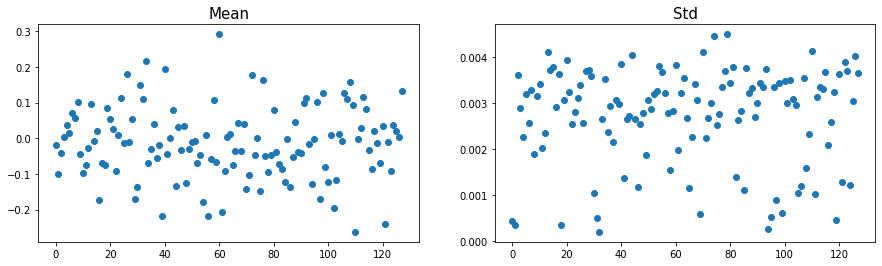

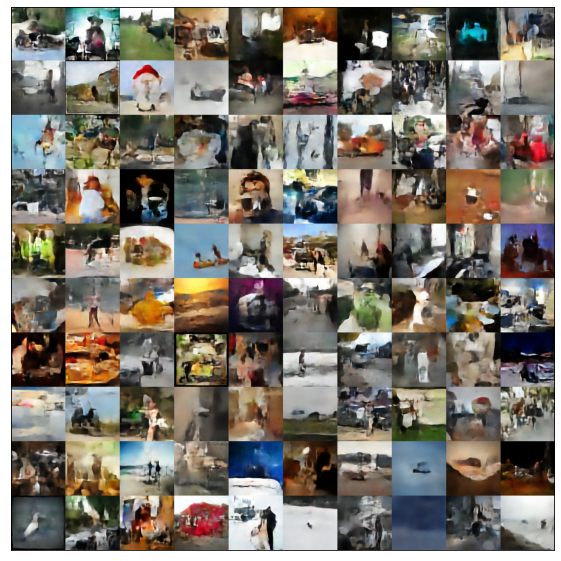

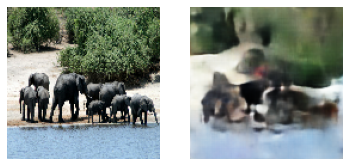

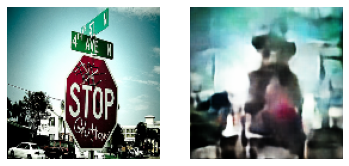

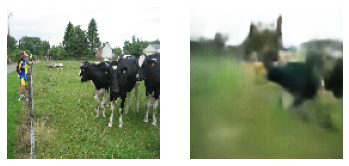

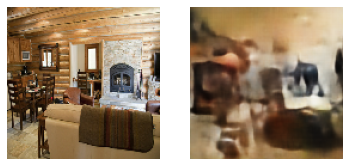

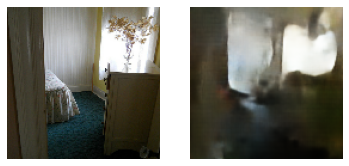

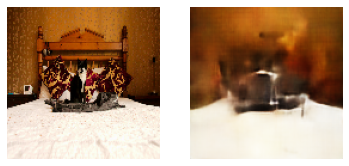

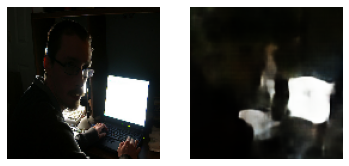

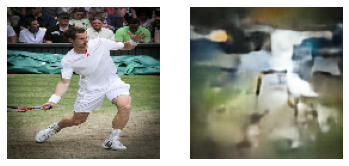

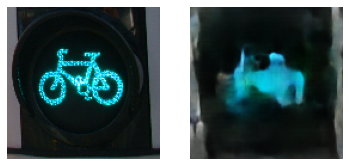

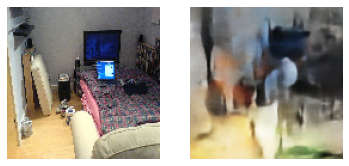

In [7]:
show_pred_images(en, dec, train_dataset, 'train images')
show_pred_images(en, dec, test_dataset, 'test images')

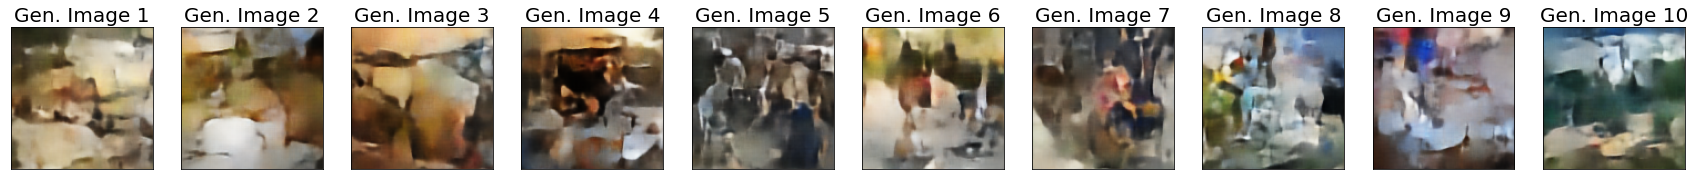

In [8]:
n = 10
eps = np.random.normal(0, 1, size=(n, latent_dim))
decoded_imgs = dec.predict(eps)

plt.figure(figsize=(30,10))
for i in range(n):
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title('Gen. Image '+ str(i+1), size=20)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()
plt.close()